# Fined Graned evaluation using prometheus

### Install libraries

In [34]:
!pip install accelerate
!pip install transformers>=4.36
!pip install optimum
!pip install bitsandbytes

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/a6/b9/44623bdb05595481107153182e7f4b9f2ef9d3b674938ad13842054dcbd8/accelerate-0.26.1-py3-none-any.whl.metadata
  Using cached accelerate-0.26.1-py3-none-any.whl.metadata (18 kB)
  Obtaining dependency information for torch>=1.10.0 from https://files.pythonhosted.org/packages/03/f1/13137340776dd5d5bcfd2574c9c6dfcc7618285035cd77240496e5c1a79b/torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Obtaining dependency information for huggingface-hub from https://files.pythonhosted.org/packages/28/03/7d3c7153113ec59cfb31e3b8ee773f5f420a0dd7d26d40442542b96675c3/huggingface_hub-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors>=0.3.1 from https://files.pythonhosted.org/packages/d0/ba/

## Prometheus eval
A Class to evaluate the LLM response using Prometheus

In [ ]:
import json
import re
import time
import torch
from transformers import pipeline
from tqdm.auto import tqdm
from transformers import AutoTokenizer, LlamaForCausalLM

class PrometheusEval:
    def __init__(self):
        self.load_model()
        
    def set_data(self, model_output_json, score_rubric_json, model_index):
        self.model_output_json = model_output_json
        self.score_rubric_json = score_rubric_json
        self.model_index = model_index
        self.model_output = self.load_data(model_output_json)
        self.score_rubric = self.load_data(score_rubric_json)
        self.criteria_score = self.load_data("criteria_score_mapping.json")
        self.type_criteria = self.load_data("type_criteria_mapping.json")
        self.task_type = self.load_data("task_type_mapping.json")
        self.prompt_data = self.get_prompt_data_2()
        self.generate_prompts()
        
    # Function to load json files
    def load_data(self, file):
        # Function to read file
        def get_file_contents(filename, encoding='utf-8'):
            with open(filename, encoding=encoding) as f:
                content = f.read()
            return content
    
        # Function to read json file
        def read_json(filename, encoding='utf-8'):
            contents = get_file_contents(filename, encoding=encoding)
            return json.loads(contents)
        return read_json(file)

    # Functin to get prompt data
    def get_prompt_data(self, no_of_examples = -1):
        if no_of_examples <= 0:
            examples = self.model_output['model_score']['examples']
            score_rubric = self.score_rubric['score_rubrics']
        else:
            examples = self.model_output['model_score']['examples'][:no_of_examples]
            score_rubric = self.score_rubric['score_rubrics'][:no_of_examples]
            
        prompt_data_list = []
        for example in examples:
            for score in score_rubric:
                if example['id'] == score['id']:
                    data_dict = {}
                    data_dict['id'] = example['id']
                    data_dict['instruction'] = example['input']
                    data_dict['reference_answer'] = example['expected_output'][0]
                    data_dict['response_to_evaluate'] = example['generated_output']
                    data_dict['criteria_description'] = score['criteria_description']
                    data_dict['score1_description'] = score['score1_description']
                    data_dict['score2_description'] = score['score2_description']
                    data_dict['score3_description'] = score['score3_description']
                    data_dict['score4_description'] = score['score4_description']
                    data_dict['score5_description'] = score['score5_description']
                    prompt_data_list.append(data_dict)
        return prompt_data_list

    def get_prompt_data_2(self, no_of_examples = -1):
        if no_of_examples <= 0:
            examples = self.model_output['model_score']['examples']
        else:
            examples = self.model_output['model_score']['examples'][:no_of_examples]
            
        criteria_score_mapping = self.criteria_score['mapping']
        type_criteria_mapping = self.type_criteria['mapping']
        task_type_mapping = self.task_type['mapping']
        
        prompt_data_list = []
        for example in examples:
            for task in task_type_mapping:
                criteria_list = []
                if example['id'] == task['task_id']:
                    type_id = task['type_id']
                    for type in type_criteria_mapping:
                        if type['id'] == type_id:
                            criteria_id_list = type['criteria_list']
                            for criteria_id in criteria_id_list:
                                criteria_dict = {}
                                for criteria in criteria_score_mapping:
                                    if criteria['id'] == criteria_id:
                                        criteria_dict['id'] = criteria['id']
                                        criteria_dict['criteria_name'] = criteria['name']
                                        criteria_dict['criteria_description'] = criteria['criteria_description']
                                        criteria_dict['score1_description'] = criteria['score1_description']
                                        criteria_dict['score2_description'] = criteria['score2_description']
                                        criteria_dict['score3_description'] = criteria['score3_description']
                                        criteria_dict['score4_description'] = criteria['score4_description']
                                        criteria_dict['score5_description'] = criteria['score5_description']
                                        criteria_list.append(criteria_dict)
                    data_dict = {}
                    data_dict['id'] = example['id']
                    data_dict['instruction'] = example['input']
                    data_dict['reference_answer'] = example['expected_output'][0]
                    data_dict['response_to_evaluate'] = example['generated_output']
                    data_dict['criteria_list'] = criteria_list
                    prompt_data_list.append(data_dict)

        return prompt_data_list
        
    # Function to get list of prompts
    def generate_prompts(self):
        
        # Function to get prompt
        def get_prompt(prompt_data):
            prompt_dict = {}
            prompt = f'''###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given. 1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general. 2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric. 3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)". 4. Please do not generate any other opening, closing, and explanations. ###The instruction to evaluate: {prompt_data['instruction']} ###Response to evaluate: {prompt_data['response_to_evaluate']} ###Reference Answer (Score 5): {prompt_data['reference_answer']} ###Score Rubrics: [{prompt_data['criteria_description']}] Score 1: {prompt_data['score1_description']} Score 2: {prompt_data['score2_description']} Score 3: {prompt_data['score3_description']} Score 4: {prompt_data['score4_description']}  Score 5: {prompt_data['score5_description']} ###Feedback:'''
            prompt_dict['example_id'] = prompt_data['id']
            prompt_dict['prompt'] = prompt
            return prompt_dict

        def generate_prompt_from_json(prompt_data):
            prompt_dict = {}
            # Generate the criteria section of the prompt
            criteria_section = ""
            for criteria in prompt_data['criteria_list']:
                criteria_section += f"\n\n[{criteria['criteria_name']}]\n[{criteria['criteria_description']}]\n"
                criteria_section += f"Score 1: {criteria['score1_description']}\n"
                criteria_section += f"Score 2: {criteria['score2_description']}\n"
                criteria_section += f"Score 3: {criteria['score3_description']}\n"
                criteria_section += f"Score 4: {criteria['score4_description']}\n"
                criteria_section += f"Score 5: {criteria['score5_description']}\n"
        
            # Generate the full prompt
            prompt = f"""###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing different evaluation criteria are given. 1. Write detailed feedback that assesses the quality of the response strictly based on the given score rubric, not evaluating in general. 2. After writing feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric. 3. The output format should look as follows: "Feedback: (write feedback a for the criteria) [RESULT] (an integer number between 1 and 5)". 4. Please do not generate any other opening, closing, and explanations.###The instruction to evaluate: {prompt_data['instruction']}###Response to evaluate: {prompt_data['response_to_evaluate']}###Reference Answer (Score 5): {prompt_data['reference_answer']} ###Score Rubrics: {criteria_section} ###Feedback:"""
            prompt_dict['example_id'] = prompt_data['id']
            prompt_dict['prompt'] = prompt
            return prompt_dict
            
        self.prompts = []
        for data in self.prompt_data:            
            #self.prompts.append(get_prompt(data))
            self.prompts.append(generate_prompt_from_json(data))
        self.save_prompts_to_json()
        return self

    # Functio to save prompts to json file
    def save_prompts_to_json(self):
        with open(f'prompts_model_{self.model_index}.json', 'w') as output_json_file:
            json.dump({"model_name": self.model_output['model_score']['model_name'], "prompts": self.prompts}, output_json_file)
    
        print(f"\nPrompts saved to  prompts_model_{self.model_index}.json")
        return self

    def extract_feedback(self, eval_output):
        # Extract Feedback and Result
        feedback = ''
        result = ''
        feedback_match = re.search(r"(.+?)\[RESULT\] (\d+)", eval_output, re.DOTALL)
        if feedback_match:
            feedback = feedback_match.group(1).strip()
            result = int(feedback_match.group(2))
        return feedback, result

    def load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token='')
        self.model = LlamaForCausalLM.from_pretrained("kaist-ai/Prometheus-13b-v1.0", device_map="auto", load_in_8bit=True)
        #self.model.to_bettertransformer()
        return self

    def generate_feedback(self, prompt):
        pipe = pipeline("text-generation", model=self.model, tokenizer=self.tokenizer)
        start_time = time.time()
        
        with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
            outputs = pipe(prompt['prompt'], max_new_tokens=256, temperature=1.0, repetition_penalty=1.03, top_p=0.9, do_sample=True, pad_token_id=2)[0]["generated_text"][len(prompt['prompt']):]
        
        feedback, result = self.extract_feedback(outputs)
        #print(feedback)
        end_time = time.time()
        duration = end_time - start_time
        print('duration: ', duration, ' seconds')

        return feedback, result, prompt['example_id']

    def save_feedback(self, feedback_list):
        eval_data = {
        "model_name": self.model_output['model_score']['model_name'],
        "feedbacks" : feedback_list
        }
    
        with open(f'eval_model_{self.model_index}.json', 'w') as output_json_file:
            json.dump({"model_score": eval_data}, output_json_file)

        print(f"\Evaluations saved to eval_model_{self.model_index}.json")

    def run_evaluation(self, test = True, index = 0):
        feedback_list = []
        if test:
            # Run single example
            feedback_dict = {}
            feedback, result, example_id = self.generate_feedback(self.prompts[index])
            feedback_dict['example_id'] = example_id
            feedback_dict['feedback'] = feedback
            feedback_dict['result'] = result
            feedback_list.append(feedback_dict)
        else:
            # Run through all examples
            for count, prompt in enumerate(tqdm(self.prompts)):
                feedback_dict = {}
                feedback, result, example_id = self.generate_feedback(prompt)
                feedback_dict['example_id'] = example_id
                feedback_dict['feedback'] = feedback
                feedback_dict['result'] = result
                feedback_list.append(feedback_dict)

        self.save_feedback(feedback_list)



2024-01-29 13:56:47.867852: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 13:56:47.900248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
eval = PrometheusEval()

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [46]:
index = 9
eval.set_data(f'score_model_{index}.json', 'score_rubric.json', index)


Prompts saved to  prompts_model_9.json


In [47]:
eval.run_evaluation(test = False, index = 4)

  0%|          | 0/20 [00:00<?, ?it/s]

duration:  27.620614528656006  seconds
duration:  25.688974857330322  seconds
duration:  25.467939853668213  seconds
duration:  22.188871383666992  seconds
duration:  29.23373770713806  seconds
duration:  21.259730577468872  seconds
duration:  31.040080547332764  seconds
duration:  23.799591064453125  seconds
duration:  18.01960062980652  seconds
duration:  18.20946979522705  seconds
duration:  17.225024461746216  seconds
duration:  22.243385553359985  seconds
duration:  18.404395580291748  seconds
duration:  19.33282160758972  seconds
duration:  21.617260217666626  seconds
duration:  20.21848487854004  seconds
duration:  23.633119344711304  seconds
duration:  28.130095720291138  seconds
duration:  21.213746786117554  seconds
duration:  18.917356491088867  seconds
\Evaluations saved to eval_model_9.json


In [41]:
import json
def combine_files(file1, file2, index):
    with open(file1, encoding='utf-8') as f:
        content = f.read()
        file1 = json.loads(content)
    with open(file2, encoding='utf-8') as f:
        content = f.read()
        file2 = json.loads(content)

    metric_score = file1['model_score']['examples']
    eval_score = file2['model_score']['feedbacks']
    
    for data1 in metric_score:
        for data2 in eval_score:
            if data1['id'] == data2['example_id']:
                data1['feedback'] = data2['feedback']
                data1['prometheus_score'] = data2['result']

    with open(f'combined_score_m{index}.json', 'w') as output_json_file:
            json.dump({"model_name": file1['model_score']['model_name'], 'result': metric_score}, output_json_file)

In [48]:
combine_files(f'score_model_{index}.json', f'eval_model_{index}.json', index)

In [19]:
import json
# Function to load json files
def load_data(file):
    # Function to read file
    def get_file_contents(filename, encoding='utf-8'):
        with open(filename, encoding=encoding) as f:
            content = f.read()
        return content

    # Function to read json file
    def read_json(filename, encoding='utf-8'):
        contents = get_file_contents(filename, encoding=encoding)
        return json.loads(contents)
    return read_json(file)

def generate_prompt_from_json(prompt_data):
    # Generate the criteria section of the prompt
    criteria_section = ""
    for criteria in prompt_data['criteria_list']:
        criteria_section += f"\n\n[{criteria['criteria_name']}]\n[{criteria['criteria_description']}]\n"
        criteria_section += f"Score 1: {criteria['score1_description']}\n"
        criteria_section += f"Score 2: {criteria['score2_description']}\n"
        criteria_section += f"Score 3: {criteria['score3_description']}\n"
        criteria_section += f"Score 4: {criteria['score4_description']}\n"
        criteria_section += f"Score 5: {criteria['score5_description']}\n"

    # Generate the full prompt
    prompt = f"""
###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing an evaluation criteria are given. 1. Write detailed feedback that assesses the quality of the response strictly based on the given score rubric, not evaluating in general. 2. After writing feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric. 3. The output format should look as follows: "Feedback: (write feedback for criteria) [RESULT] (an integer number between 1 and 5)". 4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate: {prompt_data['instruction']}
###Response to evaluate: {prompt_data['response_to_evaluate']}
###Reference Answer (Score 5): {prompt_data['reference_answer']}

###Score Rubrics: {criteria_section}

###Feedback:
"""
    return prompt
    

In [17]:
model_output = load_data("score_model_0.json")
criteria_score = load_data("criteria_score_mapping.json")
type_criteria = load_data("type_criteria_mapping.json")
task_type = load_data("task_type_mapping.json")

examples = model_output['model_score']['examples'][0]
criteria_score_mapping = criteria_score['mapping']
type_criteria_mapping = type_criteria['mapping']
task_type_mapping = task_type['mapping']

prompt_data_list = []
for task in task_type_mapping:
    criteria_list = []
    if examples['id'] == task['task_id']:
        type_id = task['type_id']
        for type in type_criteria_mapping:
            if type['id'] == type_id:
                criteria_id_list = type['criteria_list']
                for criteria_id in criteria_id_list:
                    criteria_dict = {}
                    for criteria in criteria_score_mapping:
                        if criteria['id'] == criteria_id:
                            criteria_dict['id'] = criteria['id']
                            criteria_dict['criteria_name'] = criteria['name']
                            criteria_dict['criteria_description'] = criteria['criteria_description']
                            criteria_dict['score1_description'] = criteria['score1_description']
                            criteria_dict['score2_description'] = criteria['score2_description']
                            criteria_dict['score3_description'] = criteria['score3_description']
                            criteria_dict['score4_description'] = criteria['score4_description']
                            criteria_dict['score5_description'] = criteria['score5_description']
                            criteria_list.append(criteria_dict)
        data_dict = {}
        data_dict['id'] = examples['id']
        data_dict['instruction'] = examples['input']
        data_dict['reference_answer'] = examples['expected_output'][0]
        data_dict['response_to_evaluate'] = examples['generated_output']
        data_dict['criteria_list'] = criteria_list
        prompt_data_list.append(data_dict)

In [23]:
for data in prompt_data_list:
    prompt = generate_prompt_from_json(data)

In [24]:
prompt

'\n###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing an evaluation criteria are given. 1. Write detailed feedback that assesses the quality of the response strictly based on the given score rubric, not evaluating in general. 2. After writing feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric. 3. The output format should look as follows: "Feedback: (write feedback for criteria) [RESULT] (an integer number between 1 and 5)". 4. Please do not generate any other opening, closing, and explanations.\n\n###The instruction to evaluate: I need an 80s sci-fi fantasy character introduction for my newest novel. The main character’s name is Drake, and the year is 3098.\n###Response to evaluate:  He is a time traveler who has come back in time to the 80s to stop a rogue AI from taking over the world.\n\nHere is the introduction I need:

## function to export csv reports

In [57]:
# function to export bleu csv report
import csv
import json
    
def extract_bleu_score(examples):
    try:
        text_score_list = []
        qa_score_list = []
        for example in examples:
            google_bleu = example["scores"]["google_bleu"]
            if 'tg' in example["id"]:
                text_score_list.append(round(google_bleu,3))
            if 'oqa' in example["id"]:
                qa_score_list.append(round(google_bleu,3))
        return text_score_list, qa_score_list
    except (IndexError, KeyError):
        return None

def create_csv(rows_data, file_name):
    headers = ["Model Name / Instruction Number", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "avg score"]
    with open(file_name, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(headers)
        csv_writer.writerows(rows_data)
        
def load_data(file):
        # Function to read file
        def get_file_contents(filename, encoding='utf-8'):
            with open(filename, encoding=encoding) as f:
                content = f.read()
            return content
    
        # Function to read json file
        def read_json(filename, encoding='utf-8'):
            contents = get_file_contents(filename, encoding=encoding)
            return json.loads(contents)
        return read_json(file)
    
def export_bleu_score():
    text_model_list = []
    qa_model_list = []
    for i in range(10):
        score_file = load_data(f'score_model_{i}.json')
        model_name = score_file["model_score"]["model_name"]
        examples = score_file["model_score"]["examples"]
        text_score_list, qa_score_list = extract_bleu_score(examples)

        # calculate avg
        avg_score_text = sum(text_score_list) / len(text_score_list)
        avg_score_qa = sum(qa_score_list) / len(qa_score_list)

        # add avg at the end
        text_score_list.append(round(avg_score_text,3))
        qa_score_list.append(round(avg_score_qa,3))
        
        text_score_list.insert(0, model_name)
        qa_score_list.insert(0, model_name)
        text_model_list.append(text_score_list)
        qa_model_list.append(qa_score_list)
    print("text_model_list", text_model_list)
    print("qa_model_list", qa_model_list)
                               
    create_csv(text_model_list, "bleu_score_tg.csv")
    create_csv(qa_model_list, "bleu_score_qa.csv")

In [ ]:
# function to export bert csv reports
import csv
import json
    
def extract_score(examples):
    try:
        text_score_list = []
        qa_score_list = []
        for example in examples:
            score = example["scores"]["bertscore"]["f1"][0]
            if 'tg' in example["id"]:
                text_score_list.append(round(score,3))
            if 'oqa' in example["id"]:
                qa_score_list.append(round(score,3))
        return text_score_list, qa_score_list
    except (IndexError, KeyError):
        return None

def create_csv(rows_data, file_name):
    headers = ["Model Name / Instruction Number", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "avg score"]
    with open(file_name, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(headers)
        csv_writer.writerows(rows_data)
        
def load_data(file):
        # Function to read file
        def get_file_contents(filename, encoding='utf-8'):
            with open(filename, encoding=encoding) as f:
                content = f.read()
            return content
    
        # Function to read json file
        def read_json(filename, encoding='utf-8'):
            contents = get_file_contents(filename, encoding=encoding)
            return json.loads(contents)
        return read_json(file)
    
def export_bert_score():
    text_model_list = []
    qa_model_list = []
    for i in range(10):
        score_file = load_data(f'score_model_{i}.json')
        model_name = score_file["model_score"]["model_name"]
        examples = score_file["model_score"]["examples"]
        text_score_list, qa_score_list = extract_score(examples)

        # calculate avg
        avg_score_text = sum(text_score_list) / len(text_score_list)
        avg_score_qa = sum(qa_score_list) / len(qa_score_list)

        # insert model name at the beginning of the list
        text_score_list.insert(0, model_name)
        qa_score_list.insert(0, model_name)
        
        # add avg at the end
        text_score_list.append(round(avg_score_text,3))
        qa_score_list.append(round(avg_score_qa,3))

        # add the score list to models list
        text_model_list.append(text_score_list)
        qa_model_list.append(qa_score_list)
    print("text_model_list", text_model_list)
    print("qa_model_list", qa_model_list)
                               
    create_csv(text_model_list, "bert_score_tg.csv")
    create_csv(qa_model_list, "bert_score_qa.csv")

In [1]:
# function to export rouge csv reports
import csv
import json
    
def extract_score(examples):
    try:
        text_score_list = []
        qa_score_list = []
        for example in examples:
            score = example["scores"]["rouge"]["rougeL"]
            if 'tg' in example["id"]:
                text_score_list.append(round(score,3))
            if 'oqa' in example["id"]:
                qa_score_list.append(round(score,3))
        return text_score_list, qa_score_list
    except (IndexError, KeyError):
        return None

def create_csv(rows_data, file_name):
    headers = ["Model Name / Instruction Number", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "avg score"]
    with open(file_name, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(headers)
        csv_writer.writerows(rows_data)
        
def load_data(file):
        # Function to read file
        def get_file_contents(filename, encoding='utf-8'):
            with open(filename, encoding=encoding) as f:
                content = f.read()
            return content
    
        # Function to read json file
        def read_json(filename, encoding='utf-8'):
            contents = get_file_contents(filename, encoding=encoding)
            return json.loads(contents)
        return read_json(file)
    
def export_rouge_score():
    text_model_list = []
    qa_model_list = []
    for i in range(10):
        score_file = load_data(f'score_model_{i}.json')
        model_name = score_file["model_score"]["model_name"]
        examples = score_file["model_score"]["examples"]
        text_score_list, qa_score_list = extract_score(examples)
        # calculate avg
        avg_score_text = sum(text_score_list) / len(text_score_list)
        avg_score_qa = sum(qa_score_list) / len(qa_score_list)
        
        # insert model name at the beginning of the list
        text_score_list.insert(0, model_name)
        qa_score_list.insert(0, model_name)

        # add avg at the end
        text_score_list.append(round(avg_score_text,3))
        qa_score_list.append(round(avg_score_qa,3))

        # add the score list to models list
        text_model_list.append(text_score_list)
        qa_model_list.append(qa_score_list)
        
    print("text_model_list", text_model_list)
    print("qa_model_list", qa_model_list)
                               
    create_csv(text_model_list, "rougeL_score_tg.csv")
    create_csv(qa_model_list, "rougeL_score_qa.csv")

In [60]:
# function to export prometheus csv reports
import csv
import json
    
def extract_score(examples):
        text_score_list = []
        qa_score_list = []
        for example in examples:
            score = example["result"]
            if 'tg' in example["example_id"]:
                text_score_list.append(score)
            if 'oqa' in example["example_id"]:
                qa_score_list.append(score)
        return text_score_list, qa_score_list

def create_csv(rows_data, file_name):
    headers = ["Model Name / Instruction Number", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "avg score"]
    with open(file_name, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(headers)
        csv_writer.writerows(rows_data)
        
def load_data(file):
        # Function to read file
        def get_file_contents(filename, encoding='utf-8'):
            with open(filename, encoding=encoding) as f:
                content = f.read()
            return content
    
        # Function to read json file
        def read_json(filename, encoding='utf-8'):
            contents = get_file_contents(filename, encoding=encoding)
            return json.loads(contents)
        return read_json(file)
    
def export_prometheus_score():
    text_model_list = []
    qa_model_list = []
    for i in range(10):
        score_file = load_data(f'eval_model_{i}.json')
        model_name = score_file["model_score"]["model_name"]
        feedbacks = score_file["model_score"]["feedbacks"]
        text_score_list, qa_score_list = extract_score(feedbacks)
        # calculate avg
        avg_score_text = sum(text_score_list) / len(text_score_list)
        avg_score_qa = sum(qa_score_list) / len(qa_score_list)

        # add avg at the end
        text_score_list.append(round(avg_score_text,3))
        qa_score_list.append(round(avg_score_qa,3))
        
        text_score_list.insert(0, model_name)
        qa_score_list.insert(0, model_name)
        text_model_list.append(text_score_list)
        qa_model_list.append(qa_score_list)
    print("text_model_list", text_model_list)
    print("qa_model_list", qa_model_list)
                               
    create_csv(text_model_list, "prometheus_score_tg.csv")
    create_csv(qa_model_list, "prometheus_score_qa.csv")

In [58]:
export_bert_score()
export_bleu_score()
export_rouge_score()
export_prometheus_score()

text_model_list [['TheBloke/Orca-2-13B-AWQ', 0.537, 0.735, 0.697, 0.599, 0.562, 0.689, 0.768, 0.648, 0.554, 0.657, 0.645], ['microsoft/Orca-2-7b', 0.561, 0.492, 0.653, 0.645, 0.566, 0.534, 0.622, 0.581, 0.424, 0.724, 0.58], ['01-ai/Yi-6B', 0.356, 0.624, 0.458, 0.276, 0.326, 0.648, 0.384, 0.493, 0.41, 0.426, 0.44], ['WizardLM/WizardLM-13B-V1.1', 0.569, 0.591, 0.641, 0.616, 0.558, 0.553, 0.65, 0.644, 0.592, 0.765, 0.618], ['TheBloke/WizardLM-7B-V1.0-Uncensored-GPTQ', 0.562, 0.583, 0.667, 0.5, 0.672, 0.687, 0.657, 0.637, 0.54, 0.761, 0.627], ['TheBloke/llava-v1.5-13B-AWQ', 0.542, 0.602, 0.716, 0.627, 0.572, 0.554, 0.679, 0.641, 0.548, 0.741, 0.622], ['TheBloke/vicuna-7B-v1.5-GPTQ', 0.563, 0.618, 0.655, 0.679, 0.589, 0.763, 0.7, 0.597, 0.589, 0.728, 0.648], ['TheBloke/tulu-2-dpo-13B-AWQ', 0.564, 0.589, 0.687, 0.622, 0.571, 0.599, 0.697, 0.293, 0.542, 0.742, 0.591], ['timdettmers/guanaco-7b', 0.583, 0.566, 0.693, 0.615, 0.523, 0.731, 0.685, 0.625, 0.565, 0.732, 0.632], ['TheBloke/guanaco-13

TypeError: cannot unpack non-iterable NoneType object

In [2]:
export_rouge_score()

text_model_list [['TheBloke/Orca-2-13B-AWQ', 0.109, 0.326, 0.301, 0.142, 0.193, 0.364, 0.393, 0.273, 0.163, 0.186, 0.245], ['microsoft/Orca-2-7b', 0.104, 0.147, 0.254, 0.181, 0.183, 0.123, 0.148, 0.225, 0.031, 0.28, 0.168], ['01-ai/Yi-6B', 0.072, 0.129, 0.099, 0.009, 0.0, 0.24, 0.111, 0.206, 0.095, 0.138, 0.11], ['WizardLM/WizardLM-13B-V1.1', 0.126, 0.14, 0.224, 0.141, 0.187, 0.079, 0.158, 0.222, 0.143, 0.276, 0.17], ['TheBloke/WizardLM-7B-V1.0-Uncensored-GPTQ', 0.175, 0.142, 0.239, 0.153, 0.291, 0.311, 0.227, 0.245, 0.15, 0.297, 0.223], ['TheBloke/llava-v1.5-13B-AWQ', 0.14, 0.194, 0.351, 0.153, 0.213, 0.092, 0.283, 0.242, 0.069, 0.352, 0.209], ['TheBloke/vicuna-7B-v1.5-GPTQ', 0.142, 0.176, 0.212, 0.184, 0.201, 0.385, 0.228, 0.142, 0.16, 0.275, 0.21], ['TheBloke/tulu-2-dpo-13B-AWQ', 0.135, 0.181, 0.249, 0.116, 0.191, 0.151, 0.227, 0.0, 0.197, 0.267, 0.171], ['timdettmers/guanaco-7b', 0.156, 0.093, 0.271, 0.134, 0.135, 0.364, 0.197, 0.24, 0.098, 0.191, 0.188], ['TheBloke/guanaco-13B-GPT

In [62]:
def read_last_column(csv_file):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        last_column_values = [row[-1] for row in reader]
        # Remove the header row if it exists
        if len(last_column_values) > 0 and last_column_values[0] == 'avg score':
            last_column_values.pop(0)
        return last_column_values

def create_csv(rows_data, file_name):
    headers = ["Model Name / Instruction Number", "bleu", "bert", "rouge", "prometheus"]
    with open(file_name, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(headers)
        csv_writer.writerows(rows_data)

In [63]:
values = read_last_column("prometheus_score_tg.csv")

In [3]:
import csv

def merge_csv_files(csv_files, new_csv_file):
    # Initialize a list to store data rows
    data_rows = []

    # Read average scores from each CSV file
    for file_path in csv_files:
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                model_name = row["Model Name / Instruction Number"]
                score = float(row["avg score"])
                data_rows.append({"Model Name / Instruction Number": model_name, file_path.split('_')[0]: score})

    # Create a new CSV file with the desired header
    #new_csv_file = 'merged_scores.csv'
    with open(new_csv_file, 'w', newline='') as file:
        fieldnames = ["Model Name / Instruction Number", "bleu", "bert", "rougeL", "prometheus"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        # Write data rows to the new CSV file
        for row in data_rows:
            writer.writerow(row)


In [5]:
# Example usage:
csv_files = ['bleu_score_tg.csv', 'bert_score_tg.csv', 'rougeL_score_tg.csv', 'prometheus_score_tg.csv']
merge_csv_files(csv_files, 'tg_merged_score.csv')

## Code to plot graphs

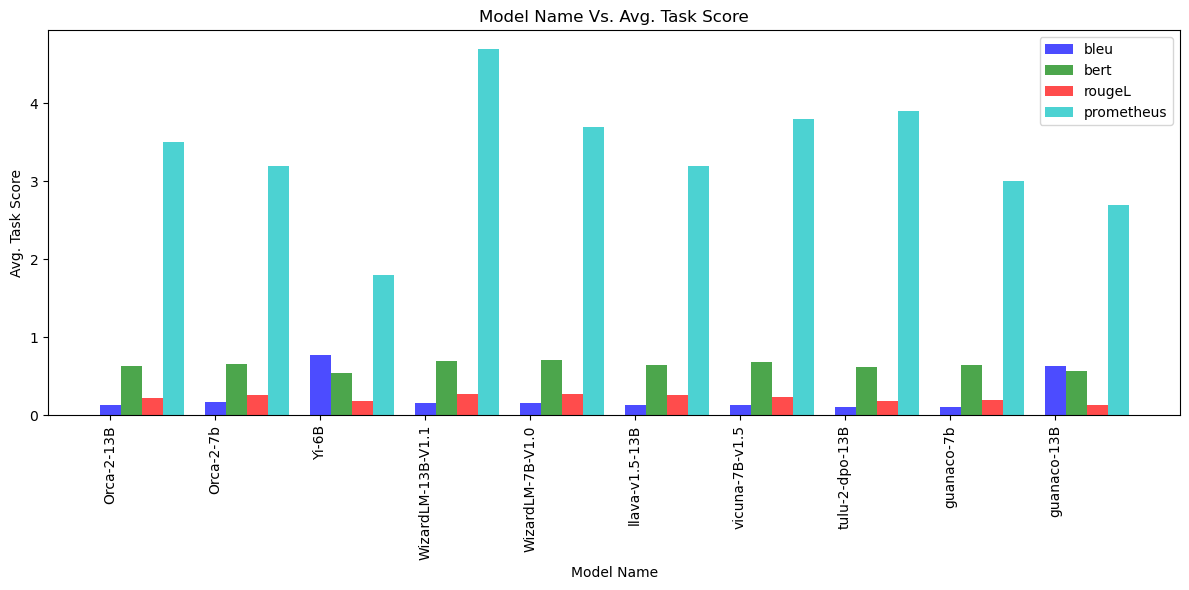

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = {
    "Model Name": [
        "Orca-2-13B",
        "Orca-2-7b",
        "Yi-6B",
        "WizardLM-13B-V1.1",
        "WizardLM-7B-V1.0",
        "llava-v1.5-13B",
        "vicuna-7B-v1.5",
        "tulu-2-dpo-13B",
        "guanaco-7b",
        "guanaco-13B",
    ],	
    "bleu": [
        0.128,
        0.168,
        0.77,
        0.154,
        0.159,
        0.135,
        0.133,
        0.112,
        0.112,
        0.63,
    ],
    "bert": [
        0.629,
        0.658,
        0.542,
        0.698,
        0.705,
        0.646,
        0.678,
        0.621,
        0.647,
        0.574,
    ],
    "rougeL": [
        0.218,
        0.256,
        0.182,
        0.277,
        0.27,
        0.258,
        0.232,
        0.18,
        0.197,
        0.129,
    ],
    "prometheus": [3.5, 3.2, 1.8, 4.7, 3.7, 3.2, 3.8, 3.9, 3.0, 2.7],
}

df = pd.DataFrame(data)

# Extract scores columns for normalization
scores = df[["bleu", "bert", "rougeL", "prometheus"]]

# Normalize scores using Min-Max scaling
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores)
# Update the DataFrame with normalized scores
#df[["bleu", "bert", "rougeL", "prometheus"]] = normalized_scores

# Define custom colors for the bars
colors = ["b", "g", "r", "c"]

plt.figure(figsize=(12, 6))
for i, col in enumerate(["bleu", "bert", "rougeL", "prometheus"]):
    plt.bar(
        df.index + i * 0.2,  # Shift bars for adjacent positioning
        df[col],
        width=0.2,
        label=col,
        color=colors[i],
        alpha=0.7,
    )

plt.xlabel("Model Name")
plt.ylabel("Avg. Task Score")
plt.title("Model Name Vs. Avg. Task Score")
plt.xticks(df.index, df["Model Name"], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## Code for pearson analysis

In [11]:
# Pearson correlation analysis for tg scores
import pandas as pd
data = {
    'bleu': [0.12, 0.84, 0.34, 0.71, 0.119, 0.11, 0.118, 0.79, 0.98, 0.09],
    'bert': [0.645, 0.58, 0.44, 0.618, 0.627, 0.622, 0.648, 0.591, 0.632, 0.581],
    'rougeL': [0.245, 0.168, 0.11, 0.17, 0.223, 0.209, 0.21, 0.171, 0.188, 0.177],
    'prometheus': [4.3, 3.2, 1.6, 5.0, 4.0, 4.0, 3.5, 4.4, 3.8, 3.2]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate correlation matrix using Pearson method
correlation_matrix = df.corr(method='pearson')

# Extract Prometheus correlations
prometheus_correlations = correlation_matrix['prometheus']
prometheus_correlations

bleu          0.169099
bert          0.806509
rougeL        0.612497
prometheus    1.000000
Name: prometheus, dtype: float64

In [12]:
# Pearson correlation analysis for qa scores
import pandas as pd
data = {
    "bleu": [
        0.128,
        0.168,
        0.77,
        0.154,
        0.159,
        0.135,
        0.133,
        0.112,
        0.112,
        0.63,
    ],
    "bert": [
        0.629,
        0.658,
        0.542,
        0.698,
        0.705,
        0.646,
        0.678,
        0.621,
        0.647,
        0.574,
    ],
    "rougeL": [
        0.218,
        0.256,
        0.182,
        0.277,
        0.27,
        0.258,
        0.232,
        0.18,
        0.197,
        0.129,
    ],
    "prometheus": [3.5, 3.2, 1.8, 4.7, 3.7, 3.2, 3.8, 3.9, 3.0, 2.7],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate correlation matrix using Pearson method
correlation_matrix = df.corr(method='pearson')

# Extract Prometheus correlations
prometheus_correlations = correlation_matrix['prometheus']
prometheus_correlations

bleu         -0.762148
bert          0.815986
rougeL        0.575397
prometheus    1.000000
Name: prometheus, dtype: float64